In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.spatial import Voronoi
from tyssue import Epithelium

from tyssue.core.generation import from_2d_voronoi
from tyssue import config
from tyssue.draw.threejs_draw import view_3js
from tyssue import SheetGeometry
from tyssue.core.objects import get_opposite
from tyssue.draw.plt_draw import quick_edge_draw

from tyssue.draw.threejs_draw import edge_lines
import pythreejs as py3js
from tyssue.draw.ipv_draw import view_ipv

import seaborn as sns
import matplotlib as mpl
import ipyvolume as ipv

from tyssue import BulkGeometry
#from tyssue.dynamics import BulkModel
from tyssue.solvers.sheet_vertex_solver import Solver

from tyssue.core.generation import extrude
from tyssue.dynamics import effectors
from tyssue.dynamics.factory import model_factory



/home/guillaume/anaconda3/envs/py36/lib/python3.6/site-packages/tyssue-0.2rc1-py3.6.egg/tyssue/core/generation.py:3: UserWarning: generation should not be imported from core anymore but from its own module
  warnings.warn('generation should not be imported from core anymore but from its own module')


You need pythreejs to use this module use conda install -c conda-forge pythreejs


ModuleNotFoundError: No module named 'pythreejs'

In [2]:
import math
def ellipse_rho(theta, a, b):
    return ((a * math.sin(theta))**2 +
            (b * math.cos(theta))**2)**0.5
    

def get_ellipsoid_centers(a, b, c, n_zs,
                          pos_err=0., phase_err=0.):

    dist = c / (n_zs)
    theta = -np.pi/2
    thetas = [theta]
    while theta < np.pi/2:
        theta = theta + dist/ellipse_rho(theta, a, c)
        thetas.append(theta)
        
    thetas = np.array(thetas).clip(-np.pi/2, np.pi/2)
    zs = c*np.sin(thetas)
    
    #np.linspace(-c, c, n_zs, endpoint=False)
    #thetas = np.arcsin(zs/c)
    av_rhos = (a + b) * np.cos(thetas) / 2
    n_cells = np.ceil(av_rhos/dist).astype(np.int)

    phis = np.concatenate(
        [np.linspace(-np.pi, np.pi, nc, endpoint=False)
         + (np.pi/nc) * (i%2) for i, nc in enumerate(n_cells)])
    
    if phase_err > 0:
        phis += np.random.normal(scale=phase_err*np.pi,
                                 size=phis.shape)

    zs = np.concatenate(
        [z * np.ones(nc) for z, nc in zip(zs, n_cells)])
    thetas = np.concatenate(
        [theta * np.ones(nc) for theta, nc in zip(thetas, n_cells)])

    xs = a * np.cos(thetas) * np.cos(phis)
    ys = b * np.cos(thetas) * np.sin(phis)
    
    if pos_err > 0.:
        xs += np.random.normal(scale=pos_err,
                               size=thetas.shape)
        ys += np.random.normal(scale=pos_err,
                               size=thetas.shape)
        zs += np.random.normal(scale=pos_err,
                               size=thetas.shape)
    centers = pd.DataFrame.from_dict(
        {'x': xs, 'y': ys, 'z': zs,
         'theta': thetas, 'phi': phis})
    return centers

#from tyssue.io import obj
from tyssue.core.generation import from_3d_voronoi
from tyssue.utils.utils import single_cell
from tyssue.dynamics import BulkModel
from tyssue import BulkGeometry
from tyssue.solvers.sheet_vertex_solver import Solver 

a, b, c = 85, 85, 150

def ellipsoid_sheet(a, b, c, n_zs, **kwargs):

    centers = get_ellipsoid_centers(a, b, c, n_zs,
                                    **kwargs)

    centers = centers.append(pd.Series(
        {'x':0, 'y':0, 'z':0,
         'theta':0, 'phi':0,}),
         ignore_index=True)

    centers['x'] /= a
    centers['y'] /= b
    centers['z'] /= c
    
    vor3d = Voronoi(centers[list('xyz')].values)
    vor3d.close()
    dsets = from_3d_voronoi(vor3d)
    veptm = Epithelium('v', dsets, config.geometry.bulk_spec())
    eptm = single_cell(veptm, centers.shape[0]-1)
    
    eptm.vert_df['rho'] = np.linalg.norm(eptm.vert_df[eptm.coords], axis=1)
    eptm.vert_df['theta'] = np.arcsin(eptm.vert_df.eval('z/rho'))
    eptm.vert_df['phi'] = np.arctan2(eptm.vert_df['y'], eptm.vert_df['x'])

    eptm.vert_df['x'] = a * np.cos(eptm.vert_df['theta']) * np.cos(eptm.vert_df['phi'])
    eptm.vert_df['y'] = b * np.cos(eptm.vert_df['theta']) * np.sin(eptm.vert_df['phi'])
    eptm.vert_df['z'] = c * np.sin(eptm.vert_df['theta'])
    eptm.settings['abc'] = [a, b, c]
    BulkGeometry.update_all(eptm)
    return eptm

eptm = ellipsoid_sheet(85, 85, 150, 
                       77, phase_err=5e-3)
print('Number of cells: {}'.format(eptm.Nf))


Number of cells: 5947


In [3]:
from tyssue.utils.utils import _to_3d
from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units


class EllipsoidGeometry(SheetGeometry):
 
    @staticmethod
    def update_height(eptm):

        a, b, c = eptm.settings['abc']
        eptm.vert_df['theta'] = np.arcsin((eptm.vert_df.z/c).clip(-1, 1))
        eptm.vert_df['vitelline_rho'] = a * np.cos(eptm.vert_df['theta'])
        eptm.vert_df['basal_shift'] = (eptm.vert_df['vitelline_rho'] -
                                       eptm.specs['vert']['basal_shift'])
        eptm.vert_df['delta_rho'] = (
            np.linalg.norm(eptm.vert_df[['x', 'y']], axis=1) - 
            eptm.vert_df['vitelline_rho']).clip(lower=0)

        SheetGeometry.update_height(eptm)
        
    @staticmethod
    def scale(eptm, scale, coords):
        SheetGeometry.scale(eptm, scale, coords)
        eptm.settings['abc'] = [u*scale for u in eptm.settings['abc']]


class EllipsoidBGeometry(EllipsoidGeometry):
        
    @staticmethod
    def update_vol(eptm):
        BulkGeometry.update_vol(eptm)

    
class VitellineElasticity(effectors.AbstractEffector):
    
    dimensions = units.line_elasticity
    magnitude = 'vitelline_K'
    label = 'Vitelline elasticity'
    element = 'vert'
    specs = {'is_active',
             'delta_rho'} # distance to the vitelline membrane
    
    @staticmethod
    def energy(eptm):
        return eptm.vert_df.eval(
            'delta_rho**2 * vitelline_K/2')
         
    @staticmethod
    def gradient(eptm):
        grad = height_grad(eptm) * _to_3d(
            eptm.vert_df.eval('vitelline_K * delta_rho'))
        grad.columns = ['g'+c for c in eptm.coords]
        return grad, None
    
EllipsoidSModel = model_factory(
    [
    VitellineElasticity,
    effectors.LineTension,
    effectors.FaceContractility,
    effectors.FaceVolumeElasticity,
    ], effectors.FaceVolumeElasticity)


EllipsoidBModel = model_factory(
    [
    VitellineElasticity,
    effectors.LineTension,
    effectors.FaceContractility,
    effectors.FaceAreaElasticity,
    effectors.CellVolumeElasticity,
    ], effectors.FaceAreaElasticity)



In [4]:

smodel = EllipsoidBModel
sgeom = EllipsoidBGeometry
#specs = config.geometry.bulk_spec()
specs = config.geometry.cylindrical_sheet()
specs['vert']['basal_shift'] = 30
specs['vert']['delta_rho'] = 30
specs['vert']['height'] = 0
specs['vert']['rho'] = 0


eptm.update_specs(specs, reset=False)

sgeom.update_all(eptm)
#specs = config.dynamics.quasistatic_sheet_spec()
specs = config.dynamics.quasistatic_bulk_spec()

print('Mean area: {}'.format(eptm.face_df.area.mean()),
      'Mean_height: {}'.format(eptm.vert_df.height.mean()),
      sep='\n')

specs['face']['prefered_area'] = 28
specs["face"]['area_elasticity'] = 1
specs['face']['prefered_height'] = 32
pref_vol = specs['face']['prefered_area'] * specs['face']['prefered_height']
specs['face']['prefered_vol'] = pref_vol
a, b, c = eptm.settings['abc']
specs['cell']['prefered_vol'] = 4*np.pi*a*b*c/3
specs['cell']['vol_elasticity'] = 1 / eptm.Nf

specs['edge']['line_tension'] = 0.
specs['vert'] = {}
specs['vert']['vitelline_K'] = 10

specs['edge']['is_active'] = 1

dim_specs = smodel.dimensionalize(specs)
eptm.update_specs(dim_specs, reset=True)

anterior_tip = eptm.vert_df[
    eptm.vert_df.z < eptm.vert_df.z.quantile(0.25)].index
posterior_tip = eptm.vert_df[
    eptm.vert_df.z > eptm.vert_df.z.quantile(0.75)].index

eptm.vert_df.loc[anterior_tip, 'is_active'] = 0
eptm.vert_df.loc[posterior_tip, 'is_active'] = 0


Reseting datasets values with new specs


Mean area: 23.45248160716011
Mean_height: 30.0


In [6]:
ipv.clear()
fig, mesh = view_ipv(eptm, color=eptm.vert_df.y)

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[ 0.545524,  0.838039,  0.275626],
       [ 0.606045,  0.850733,  0.236712],
       [ 0.626579,  0.854645,  0.223353],
       ..., 
       [ 0.28229 ,  0.145912,  0.46151 ],
       [ 0.281887,  0.150881,  0.465405],
       [ 0.280868,  0.160771,  0.472899]]), lines=array([[ 8117,  8118],
       [  647,   668],
       [ 2482,  2481],
       ..., 
       [ 5305, 10000],
       [10002, 10000],
       [   50,     0]], dtype=uint32), texture=None, x=array([-41.99852518,  39.66096893,  49.10260239, ...,  34.07090729,
        38.42497577,  38.31434844]), y=array([ 55.42354443,  59.51347147,  60.80594432, ..., -67.5940812 ,
       -66.94720931, -65.55736534]), z=array([ 86.26063237,  81.06426243,  58.96789392, ..., -68.23762968,
       -62.8045015 , -67.41182368]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-164.90241940388492, 164.94861310056532], ylim=[-164.90241940388492, 164.94861310056532], zlim=[-164.90241940388492, 164.94861310056532]),))

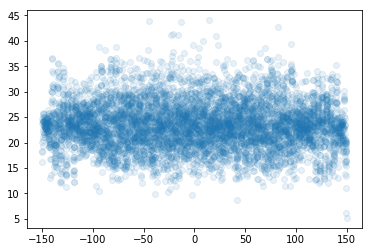

In [7]:
fig, ax = plt.subplots()
ax.plot(eptm.face_df.z, eptm.face_df.area, 'o', alpha=0.1)

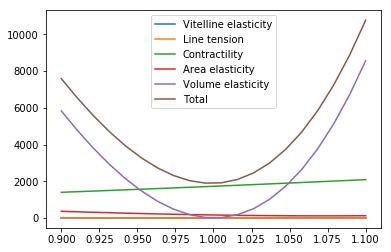

In [9]:
scales = np.linspace(0.9, 1.1, 20)
energies = []
for scale in scales:
    sgeom.scale(eptm, scale, eptm.coords)
    sgeom.update_all(eptm)
    energies.append([E.sum() for E in 
                     smodel.compute_energy(eptm, full_output=True)])
    sgeom.scale(eptm, 1/scale, eptm.coords)
    sgeom.update_all(eptm)

energies = np.array(energies).T
fig, ax = plt.subplots()
for en, lbl in zip(energies, smodel.labels):
    ax.plot(scales, en, label=lbl)
ax.plot(scales, energies.sum(axis=0), label='Total')
_ = ax.legend()


In [10]:
scales[np.argmin(energies.sum(axis=0))] 

0.99473684210526325

In [17]:

Solver.find_energy_min(eptm, sgeom, smodel)

ipv.clear()
fig, mesh = view_ipv(eptm, color=eptm.vert_df.rho)

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[ 0.496615,  0.826376,  0.306377],
       [ 0.555484,  0.840254,  0.269281],
       [ 0.751884,  0.874951,  0.143228],
       ..., 
       [ 0.126453,  0.570633,  0.549841],
       [ 0.974417,  0.90359 ,  0.130215],
       [ 0.845561,  0.887322,  0.099702]]), lines=array([[8093, 8094],
       [ 646,  667],
       [2474, 2473],
       ..., 
       [5288, 9970],
       [9972, 9970],
       [  50,    0]], dtype=uint32), texture=None, x=array([-41.99852518,  39.66096893,  49.44443438, ...,  44.4475919 ,
       -64.18175957,  38.82225654]), y=array([ 55.42354443,  59.51347147,  60.01837161, ...,  -0.85070265,
        55.50220273,  70.72905178]), z=array([  86.26063237,   81.06426243,   59.82712303, ...,  127.70562792,
          1.62482639,  -45.84562198]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-164.90241940388483, 164.9486131005653], ylim=[-164.90241940388483, 164.9486131005653], zlim=[-164.90241940388483, 164.9486131005653]),))

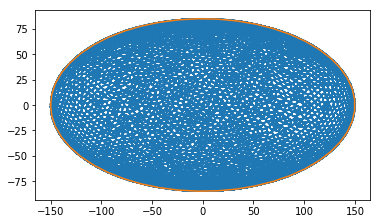

In [18]:
fig, ax = quick_edge_draw(eptm, coords=['z', 'x'])
thetas = np.linspace(-np.pi, np.pi)
ax.plot(c*np.cos(thetas), a*np.sin(thetas))

In [14]:
import json
with open('ellipsoid.json', 'w+') as js:
    json.dump(eptm.specs, js)

In [15]:
cp ellipsoid.json ../leg-disk/data/json/ellipsoid.json

In [16]:
from tyssue.topology.sheet_topology import resolve_t1s

eptm.settings["threshold_length"] = 1e-3

resolve_t1s(eptm, sgeom, smodel, Solver)

In [19]:
from tyssue.io.hdf5 import save_datasets

save_datasets('data/hf5/ellipsoid_sheet_init.hf5', eptm)

In [15]:

!cp data/hf5/ellipsoid_sheet_init.hf5 ../leg-disk/data/hf5/ellipsoid_sheet_init.hf5

In [ ]:
# morphologie de la cuvette -> 

In [66]:
is_fold_patch = ((eptm.face_df.z > eptm.face_df.z.quantile(0.1)) &
                 (eptm.face_df.z < eptm.face_df.z.quantile(0.9)) &
                 (eptm.face_df.x > eptm.face_df.x.quantile(0.3)) &
                 (eptm.face_df.x < eptm.face_df.x.quantile(0.7)) &
                 (eptm.face_df.y > 0))

fold_patch = eptm.face_df[is_fold_patch].index
print(fold_patch.size)
xs = eptm.face_df.loc[fold_patch, 'x']
width = (eptm.face_df.x.quantile(0.7)
         - eptm.face_df.x.quantile(0.3))/2.
gauss = 10 * np.exp(-xs**2/width**2)

eptm.face_df.loc[fold_patch, 'contractility'] = eptm.face_df.loc[fold_patch, 'contractility']*(1 + gauss)

edge_ctr = eptm.upcast_face(eptm.face_df.contractility)
Solver.find_energy_min(eptm, sgeom, smodel)

ipv.clear()
fig, mesh = view_ipv(eptm, color=edge_ctr)

753


/home/guillaume/miniconda3/envs/tyssue/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[ 0.267004,  0.004874,  0.329415],
       [ 0.267004,  0.004874,  0.329415],
       [ 0.964894,  0.902323,  0.123941],
       ..., 
       [ 0.267004,  0.004874,  0.329415],
       [ 0.267004,  0.004874,  0.329415],
       [ 0.267004,  0.004874,  0.329415]]), lines=array([[10794, 10790],
       [ 6269,  6268],
       [ 6352,  6353],
       ..., 
       [  415,  4606],
       [ 3365,  3367],
       [    1,     0]], dtype=uint32), texture=None, x=array([-12.07313654, -11.70377363,  -3.86459606, ..., -55.18760135,
       -56.4773266 , -55.00691368]), y=array([ 46.04178212,  45.37153558,  71.72404751, ..., -63.29498482,
       -61.39574087, -62.52981897]), z=array([-124.27581651, -125.15044092,  -80.20633675, ...,  -25.77808534,
        -30.06219996,  -31.49929305]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-164.9016524656919, 164.94852760699445], ylim=[-164.9016524656919, 164.94852760699445], zlim=[-164.9016524656919, 164.94852760699445]),))

In [37]:
ipv.clear()
fig, mesh = view_ipv(eptm, color=(eptm.vert_df.y * (eptm.vert_df.y  > 10)))

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array([[ 0.657642,  0.860219,  0.203082],
       [ 0.535621,  0.835785,  0.281908],
       [ 0.19109 ,  0.708366,  0.482284],
       ..., 
       [ 0.267004,  0.004874,  0.329415],
       [ 0.267004,  0.004874,  0.329415],
       [ 0.267004,  0.004874,  0.329415]]), lines=array([[ 3956,  1482],
       [ 1328,   614],
       [ 8114,  8115],
       ..., 
       [ 7973, 10039],
       [10042, 10043],
       [   98,     0]], dtype=uint32), texture=None, x=array([-27.26532939,  -5.30846532, -36.51366006, ..., -30.40261579,
       -26.90467306, -26.3970448 ]), y=array([ 64.1965224 ,  60.724914  ,  48.1782521 , ..., -11.95494582,
       -14.58917076, -13.37320415]), z=array([ -55.41053403,   79.38394339,   88.54162002, ...,  136.18065357,
        139.12654674,  140.61675926]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-164.90137991520461, 164.9485303412854], ylim=[-164.90137991520461, 164.9485303412854], zlim=[-164.90137991520461, 164.9485303412854]),))

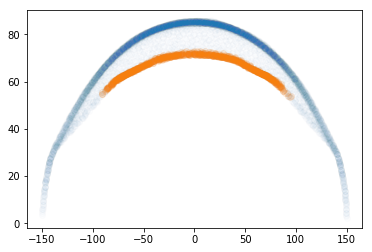

In [19]:
fig, ax = plt.subplots()
ax.scatter(eptm.face_df.z, eptm.face_df.rho, alpha=0.01)
ax.scatter(eptm.face_df.loc[fold_patch, 'z'],
           eptm.face_df.loc[fold_patch, 'rho'], alpha=0.1)


In [29]:
dsets = {'edge': eptm.edge_df, 
         'vert': eptm.vert_df,
         'face': eptm.face_df}
eptm3 = Epithelium('3d', extrude(dsets, scale=0.9),
                   config.geometry.bulk_spec())
eptm3.update_specs(config.dynamics.quasistatic_bulk_spec())

In [106]:
eptm.face_df['theta'] = np.arctan2(eptm.face_df['y'], eptm.face_df['x'])

faces = eptm.face_df.sort_values(['z', 'theta']).index


left_faces = eptm.face_df[eptm.face_df['z'] < -149].index
right_faces = eptm.face_df[eptm.face_df['z'] > 149].index

merge_faces(eptm, left_faces)
merge_faces(eptm, right_faces)
eptm.reset_index()
eptm.reset_topo()

dbles = eptm.vert_df[eptm.edge_df.groupby('srce').apply(len)==2].index
sts = eptm.edge_df.reset_index().set_index('srce').loc[dbles][['edge', 'trgt']]
tss = eptm.edge_df.reset_index().set_index('trgt').loc[dbles][['edge', 'srce']]

kept_es = sts['edge'].values[::2]
deld_es = sts['edge'].values[1::2]
n_srces = tss['srce'].values[1::2]
n_trgts = sts['trgt'].values[::2]
eptm.edge_df.loc[kept_es, 'srce'] = n_srces
eptm.edge_df.loc[kept_es, 'trgt'] = n_trgts
eptm.edge_df = eptm.edge_df.drop(deld_es, axis=0)

eptm.reset_index()
eptm.reset_topo()


In [109]:
faces[:60]

Int64Index([ 387, 3635, 4062, 3642, 2124, 4362, 2759, 4363,  533, 3808, 2082,
            3523, 2834, 2551, 3048, 3180, 4566, 3098, 3498, 3170, 4560, 2187,
            2895, 2188, 2897, 3007, 1621, 2832, 3543, 2889,  535, 1060, 2890,
            1057, 2069, 2063,  539,  538, 1353, 3842, 3542, 1844,  304,  595,
            3835, 1838, 3829, 2802, 3815, 3816, 3538, 1362, 4325, 2763, 3483,
            5096, 4275, 5107, 2526, 5068],
           dtype='int64', name='face')

In [116]:
for triples in zip(faces[:60:3],
                   faces[1:60:3],
                   faces[2:60:3]):
    merge_faces(eptm, list(triples))
    
eptm.reset_index()
eptm.reset_topo()

In [39]:
from tyssue.io.hdf5 import save_datasets

In [20]:
save_datasets('data/hf5/ellipsoid.hf5', eptm)

/home/guillaume/miniconda3/envs/tyssue/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: FutureWarning: get_store is deprecated and be removed in a future version
HDFStore(path, **kwargs) is the replacement
  interactivity=interactivity, compiler=compiler, result=result)


In [76]:
def merge_faces(eptm, faces):
    eptm.edge_df['opposite'] = get_opposite(eptm.edge_df)
    edges = pd.concat([eptm.edge_df[eptm.edge_df['face'] == face]
                       for face in faces])
    border = set(edges.index).difference(edges['opposite'])
    inner = set(edges.index).difference(border)

    eptm.edge_df.loc[border, 'face'] = faces[0]
    eptm.edge_df = eptm.edge_df.drop(inner, axis=0)
    eptm.face_df = eptm.face_df.drop(faces[1:], axis=0)
    eptm.vert_df = eptm.vert_df.loc[eptm.edge_df['srce'].unique()]
    

In [34]:
Solver.find_energy_min(eptm, BulkGeometry, BulkModel)

      fun: 53199.729725443598
 hess_inv: <19332x19332 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.34352583,  0.2339436 ,  1.67685178, ...,  0.37345463,
       -0.04033939,  0.10396614])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 14
   status: 0
  success: True
        x: array([  62.08985624,   41.98073496,  -71.00034982, ...,  -18.93945027,
         -8.01193836,  145.63743173])

In [101]:
render, scene = view_3js(eptm)

render

In [79]:
eptm.update_specs(config.dynamics.quasistatic_sheet_spec(), reset=False)
eptm.update_specs(config.geometry.spherical_sheet(), reset=False)



In [97]:
from tyssue.topology.sheet_topology import type1_transition

def resolve_t1s(sheet, geom, model, solver, max_iter=60):

    l_th = sheet.settings['threshold_length']
    i = 0
    while sheet.edge_df.length.min() < l_th:

        for edge in sheet.edge_df[sheet.edge_df.length < l_th].sort_values('length').index:
            try:
                type1_transition(sheet, edge)
            except KeyError:
                continue
            sheet.reset_index()
            sheet.reset_topo()
            geom.update_all(sheet)
        solver.find_energy_min(sheet, geom, model)
        i += 1
        if i > max_iter:
            break

In [98]:
eptm.settings['threshold_length'] = 1e-2


In [99]:
resolve_t1s(eptm, SheetGeometry, SheetModel, Solver, max_iter=60)

In [58]:
from tyssue.dynamics import SheetModel as smodel

In [59]:
SheetGeometry.update_all(eptm)

In [61]:
eptm.face_df.area.mean()

34.26561098967138

In [62]:
eptm.vert_df.height.mean()

116.52571923189016

In [82]:
eptm.specs['face']['prefered_area'] = 35
eptm.specs['face']['prefered_height'] = 120


In [83]:
dim_specs = SheetModel.dimentionalize(eptm.specs)

In [84]:
dim_specs

{'cell': {'area': 0.0,
  'area_elasticity': 1.0,
  'is_alive': True,
  'num_faces': 6,
  'prefered_area': 1.0,
  'prefered_vol': 1.0,
  'vol': 0.0,
  'vol_elasticity': 1.0,
  'x': 0.0,
  'y': 0.0,
  'z': 0.0},
 'edge': {'cell': 0,
  'dx': 0.0,
  'dy': 0.0,
  'dz': 0.0,
  'face': 0,
  'length': 0.0,
  'line_tension': 357804.5052818648,
  'nx': 0.0,
  'ny': 0.0,
  'nz': 1.0,
  'srce': 0,
  'sub_area': 0.0,
  'sub_vol': 0.0,
  'trgt': 0},
 'face': {'area': 1.0,
  'contractility': 20160.000000000004,
  'is_alive': True,
  'num_sides': 6,
  'perimeter': 1.0,
  'prefered_area': 35,
  'prefered_height': 120,
  'prefered_vol': 4200,
  'vol_elasticity': 1.0,
  'x': 0.0,
  'y': 0.0,
  'z': 0.0},
 'settings': {'geometry': 'spherical',
  'grad_norm_factor': 2981704.2106822063,
  'height_axis': 'z',
  'nrj_norm_factor': 17640000.0},
 'vert': {'basal_shift': 4.0,
  'height': 0.0,
  'is_active': True,
  'radial_tension': 0.0,
  'rho': 0.0,
  'x': 0.0,
  'y': 0.0,
  'z': 0.0}}

In [85]:
eptm.face_df['prefered_area'] = dim_specs['face']['prefered_area']
eptm.face_df['prefered_height'] = dim_specs['face']['prefered_height']
eptm.face_df['prefered_vol'] = (dim_specs['face']['prefered_area'] *
                                dim_specs['face']['prefered_height'])
eptm.edge_df['line_tension'] = dim_specs['edge']['line_tension']
eptm.face_df['contractility'] = dim_specs['face']['contractility']


In [73]:
obj.save_junction_mesh('messed_ellipsoid.obj', eptm)

                be advised the file cannot be read back in vispy


In [162]:
%pdb

Automatic pdb calling has been turned OFF


In [ ]:
from tyssue.topology.sheet_topology import 

In [86]:
Solver.find_energy_min(eptm, SheetGeometry, SheetModel)

      fun: 48346906308.481812
 hess_inv: <34155x34155 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 13231.31684091,  48254.44578077, -20385.72159235, ...,
        32753.20555111, -17284.70208027,   5440.55275702])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1936
      nit: 1929
   status: 0
  success: True
        x: array([ -20.11150771,  -29.84384427, -143.25283861, ...,  -17.90791184,
         26.42780344,  150.15151277])

In [11]:
from tyssue.utils import data_at_opposite

def merge_eptms(eptms):
    
    Nes = np.cumsum([eptm.edge_df.index.max()+1
                     for eptm in eptms])
    Nes -= Nes[0]
    Nvs = np.cumsum([eptm.vert_df.index.max()+1
                     for eptm in eptms])
    Nvs -= Nvs[0]
    Nfs = np.cumsum([eptm.face_df.index.max()+1
                     for eptm in eptms])
    Nfs -= Nfs[0]
    for i, eptm in enumerate(eptms):
        eptm.edge_df.index += Nes[i]
        eptm.edge_df.index.name='edge'
        eptm.edge_df[['srce', 'trgt']] += Nvs[i]
        eptm.edge_df['face'] += Nfs[i]
        eptm.vert_df.index += Nvs[i]
        eptm.face_df.index += Nfs[i]
    
    concat_dsets = {key: pd.concat([eptm.datasets[key]
                                    for eptm in eptms])
                    for key in ['edge', 'vert', 'face']}
    
    m_eptm = Epithelium('m', concat_dsets, eptm.specs)
    #cc_eptm = Epithelium('cc', concat_dsets, eptm.specs)
    #cc_eptm.sanitize()
    #cc_eptm.reset_index()

    return m_eptm
        


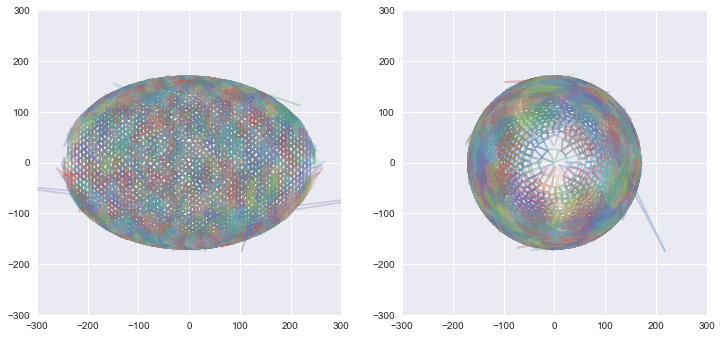

In [167]:
radius = 25
n_cells = centers.shape[0]
n_samples = 600
step = n_cells // n_samples


eptms = [local_voro(centers, radius, face)
         for face in np.arange(0, n_cells, step)]


fig, axes = plt.subplots(1, 2)
for eptm in eptms:
    quick_edge_draw(eptm, ax=axes[0], coords=['z', 'y'], alpha=0.3)
    quick_edge_draw(eptm, ax=axes[1], coords=['x', 'y'], alpha=0.3)

axes[0].set(xlim=(-300, 300),
            ylim=(-300, 300),
            aspect='equal')
axes[1].set(xlim=(-300, 300),
            ylim=(-300, 300),
            aspect='equal')

fig.set_size_inches(12, 8)

In [161]:
def local_voro(centers, radius, face,
               coords=['x', 'y', 'z']):
    
    neighbs = centers[coords].copy()
    for c in coords:
        neighbs[c] -= neighbs.loc[face, c]
    
    rel_dist = np.linalg.norm(neighbs, axis=1)
    
    neighbs = neighbs[rel_dist < 2*radius]
    U, s, V = np.linalg.svd(neighbs.values,
                            full_matrices=False,
                            compute_uv=True)
    rotated = np.dot(neighbs.values, V.T)
    f_ids = neighbs.index
    # voro = Voronoi(rotated[:, [0, 1]])
    dsets = from_2d_voronoi(Voronoi(rotated[:, [0, 1]]))
    dsets['face']['z'] = rotated[:, 2]
    dsets['face']['id'] = f_ids.values
    eptm = Epithelium('loc', dsets, config.geometry.flat_sheet())
    eptm.edge_df['face_z'] = eptm.upcast_face(
        eptm.face_df['z'])
    eptm.edge_df['face_id'] = eptm.upcast_face(
        eptm.face_df['id'])
    eptm.vert_df['z'] = eptm.edge_df.groupby('srce')['face_z'].mean()
    eptm.vert_df[['x', 'y', 'z']] = np.dot(eptm.vert_df[['x', 'y', 'z']].values, V)

    for c in coords:
        eptm.vert_df[c] += centers.loc[face, c]
    eptm.sanitize()
    eptm.reset_index()
    eptm.edge_df['opposite'] = get_opposite(eptm.edge_df)
    eptm.edge_df['opp_face_id'] = data_at_opposite(eptm, eptm.edge_df['face_id'])
    free = eptm.edge_df[eptm.edge_df['opposite']<0].index
    eptm.remove(free)
    eptm.reset_index()
    SheetGeometry.update_all(eptm)
    return eptm
    

In [169]:
m_eptm = merge_eptms(eptms)



In [170]:
#m_eptm = merge_eptms(eptms)

face_ids = m_eptm.edge_df.groupby('srce')['face_id'].apply(frozenset)
face_ids.index.name = 'vert'
m_eptm.vert_df['face_ids'] = face_ids
m_eptm.vert_df['nf'] = m_eptm.vert_df['face_ids'].apply(len)

m_eptm.edge_df['face'] = m_eptm.edge_df['face_id']
m_eptm.face_df  = m_eptm.face_df.groupby('id').mean()

singles = m_eptm.vert_df.face_ids.drop_duplicates().index
is_in = m_eptm.edge_df.srce.apply(lambda x: x in singles)
#m_eptm.edge_df = m_eptm.edge_df[is_in]

good_vs = (m_eptm.vert_df['nf'] == 3)
#m_eptm.vert_df = m_eptm.vert_df[good_vs]
#m_eptm.edge_df = m_eptm.edge_df[m_eptm.upcast_srce(good_vs)]



In [171]:
uids = m_eptm.vert_df[m_eptm.vert_df['nf']==3].groupby('face_ids').apply(
    lambda df: set(df.index)).reset_index(drop=True)

In [172]:
m_eptm.vert_df['uid'] = np.nan
for new_id, idxs in uids.iteritems():
    m_eptm.vert_df.loc[idxs, 'uid'] = new_id


In [173]:
m_eptm.edge_df['srce'] = m_eptm.upcast_srce(m_eptm.vert_df['uid'])
m_eptm.edge_df['trgt'] = m_eptm.upcast_trgt(m_eptm.vert_df['uid'])
m_eptm.vert_df = m_eptm.vert_df.groupby('uid').mean()
m_eptm.vert_df.index.name = 'vert'
m_eptm.vert_df = m_eptm.vert_df.dropna()
m_eptm.edge_df = m_eptm.edge_df.dropna()


In [174]:
from tyssue.topology.base_topology import close_face

In [100]:
render, scene = view_3js(m_eptm)

render

NameError: name 'm_eptm' is not defined

In [270]:
m_eptm.sanitize()

In [180]:
SheetGeometry.update_all(m_eptm)

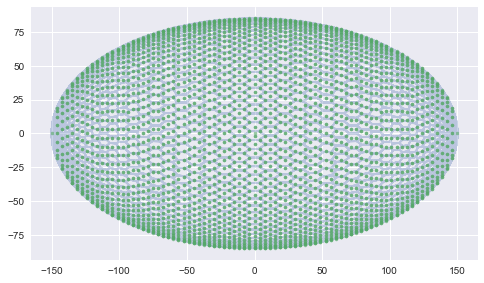

In [50]:
fig, ax = quick_edge_draw(eptm, ['z', 'x'], alpha=0.3)
ax.plot(centers['z'], centers['x'], '.', alpha=0.6)